### Model

In [12]:
import libs.forward_model as fm
import libs.read_data as rd
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import scipy.io

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
# Parameter Definition
NA = .5
Rindex = 1
lambda_ = 532.0/ 1000 #um
dx, dy, dz = 0.2, 0.2, 0.5 #um
ep_dx, ep_dy = 1, 1 #um

Nx,Ny,Nz = 25,25,11
m = 16

fm.init_parameters(NA_=NA, Rindex_=Rindex, lambda_=lambda_, dx_=dx, dy_=dy, dz_=dz, Nx_=Nx, Ny_=Ny, Nz_=Nz)
fm.init_DMD_patterns(m, ep_dx__=ep_dx, ep_dy__=ep_dy)
rd.init_parameters(Nx,Ny,Nz)
fm.init_one_shot(m)

def one_shot_model(X):
    return torch.matmul(fm.A,X)

print(f"Shape of matrix A: {fm.A.shape}")

Sucessfully Initialized Point Spread Function...!!!
Sucessfully Initialized Read Data Parameters...!!!
Matrix A is intialized sucessfully...!!!
Shape of matrix A: torch.Size([10000, 6875])


#### TwIST reconstruction

$$
\text{argmin}_x \left( \frac{1}{2} \lVert y - Ax \rVert^2 + \lambda \phi(x) \right)
$$

In [19]:
def add_gaussian_noise(signal, snr_dB):
    signal_power = torch.mean(signal**2)
    snr = 10**(snr_dB / 10.0)
    noise_power = signal_power / snr
    noise = torch.randn_like(signal) * torch.sqrt(noise_power)
    noisy_signal = signal + noise
    return noisy_signal


# store y,A,x
rd.load_object("neural_cell", verbose=False)
X_original = (rd.X).flatten()
Y = one_shot_model(X_original)

desired_snr_dB = 10.0
Y_noisy = add_gaussian_noise(Y, desired_snr_dB)

# Convert Torch tensors to NumPy arrays
A_np = fm.A.numpy()
X_original_np = X_original.numpy()
Y_np = Y.numpy()
Yn_np = Y_noisy.numpy()

# Create a dictionary to store the matrices with appropriate variable names
mat_dict = {'A': A_np, 'X_original': X_original_np, 'Y': Y_np, 'Yn': Yn_np}

# Save the dictionary to a .mat file
scipy.io.savemat('neural_cell_m_16_x_25x25x11_50dB.mat', mat_dict)


***lstsq reconstruction***

Mean Squared Error: 0.015286420471966267


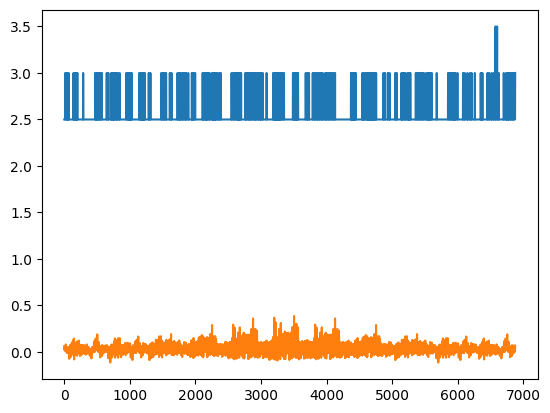

In [20]:
X_reconstructed = torch.linalg.lstsq(fm.A,Y_noisy).solution   

plt.plot(X_original+2.5)
plt.plot(X_reconstructed)
plt.show

mse = F.mse_loss(X_original, X_reconstructed)
print("Mean Squared Error:", mse.item())

In [9]:
ATA = (fm.A.T@fm.A).float()
print("Conditional Number: ","{:.4e}".format(torch.linalg.cond(ATA)))
print(f"Rank : {torch.linalg.matrix_rank(ATA)}")

Conditional Number:  4.1577e+11
Rank : 260
